## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [61]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, roc_auc_score, auc

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [62]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)
all_xray_df.tail(20)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
112100,00030789_000.png,Infiltration,0,30789,52,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030789_000.png
112101,00030790_000.png,No Finding,0,30790,47,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030790_000.png
112102,00030791_000.png,No Finding,0,30791,49,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030791_000.png
112103,00030791_001.png,No Finding,1,30791,49,M,AP,3056,2544,0.139000,0.139000,NaN,/data/images_012/images/00030791_001.png
112104,00030792_000.png,No Finding,0,30792,10,F,PA,1775,1712,0.194311,0.194311,NaN,/data/images_012/images/00030792_000.png
112105,00030792_001.png,No Finding,1,30792,10,F,PA,1663,1675,0.194311,0.194311,NaN,/data/images_012/images/00030792_001.png
112106,00030793_000.png,Mass|Nodule,0,30793,58,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030793_000.png
112107,00030794_000.png,No Finding,0,30794,38,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030794_000.png
112108,00030795_000.png,Pleural_Thickening,0,30795,53,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030795_000.png
112109,00030796_000.png,No Finding,0,30796,44,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030796_000.png


In [63]:
#all_xray_df_MF = all_xray_df.replace('M', 1).replace('F', 0)
#all_xray_df_MF.head(20)
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x : x.split('|')).tolist())))
all_labels = [ x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1: # Leaves out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(10)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12008,00003129_006.png,Atelectasis|Emphysema,6,3129,61,M,AP,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43796,00011285_003.png,Mass,3,11285,63,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
61158,00015079_001.png,No Finding,1,15079,38,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
78740,00019317_000.png,No Finding,0,19317,42,F,PA,2534,2627,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
70071,00017248_002.png,Infiltration,2,17248,55,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
76780,00018865_000.png,No Finding,0,18865,68,F,PA,2638,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7976,00002086_000.png,No Finding,0,2086,13,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
110863,00030222_002.png,Infiltration,2,30222,7,M,PA,1876,1477,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
85608,00021112_006.png,No Finding,6,21112,59,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
79956,00019643_009.png,Edema|Infiltration,9,19643,31,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

#from itertools import chain

#all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
#all_labels = [x for x in all_labels if len(x)>0]
#print('All Labels ({}): {}'.format(len(all_labels), all_labels))
#for c_label in all_labels:
#    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
#all_xray_df['Number of Diseases'] = all_xray_df['Finding Labels'].map(lambda finding: 0 if finding == 'No Finding' else finding.count('|') + 1)
#all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda b: 'yes' if b else 'no')
#sum(all_xray_df['pneumonia_class']==1)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


0

[Text(0, 0.5, 'Number of Images with Label')]

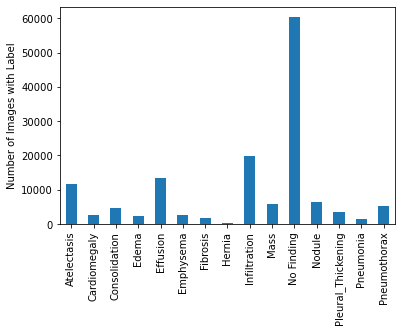

In [57]:
len(all_labels)
all_xray_df[all_labels].sum() / len(all_xray_df)
ax = all_xray_df[all_labels].sum().plot(kind = 'bar')
ax.set(ylabel = 'Number of Images with Label')

In [97]:
#plt.figure(figsize = (6, 6))
#all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts().plot(kind = 'bar')
#all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: int(x))
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda b: 'True' if b==1.0 else 'False')
#plt.figure(figsize = (6, 6))
#all_xray_df[all_xray_df.pneumonia_class == 1]['Patient Gender'].value_counts().plot(kind = 'bar')
sum(all_xray_df['pneumonia_class']=='True')

1431

In [98]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

## Create your training and testing data:

In [99]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    return train_data, val_data

In [100]:
def create_datasplits(all_xray_df):
    train_data, val_data = skl.train_test_split(all_xray_df,
                                                test_size = 0.25,
                                                shuffle = True,
                                                random_state = 2018
                                               )
    #print('Training-Set', train_data[0], 'Validation-Set', val_data[0])
    return train_data, val_data

pos_df = all_xray_df[all_xray_df.pneumonia_class == 'True']
neg_df = all_xray_df[all_xray_df.pneumonia_class == 'False']

print("Classes are imbalanced")
print("Total entries in dataset", all_xray_df.shape[0])
print("Total Positive entries in the data-set", pos_df.shape[0])
print("Total Negative entries in the data-set", neg_df.shape[0])

train_pos_data, val_pos_data = create_datasplits(pos_df)

print('train_pos ', train_pos_data.shape[0])
print('validation_pos', val_pos_data.shape[0])

from sklearn.utils import shuffle
neg_df = shuffle(neg_df)
neg_df = neg_df.sample(pos_df.shape[0])
#print('Negative-df', neg_df)

train_neg_data, val_neg_data = create_datasplits(neg_df)
print('train_neg', train_neg_data.shape[0], 'validation_neg', val_neg_data.shape[0])

Classes are imbalanced
Total entries in dataset 112120
Total Positive entries in the data-set 1431
Total Negative entries in the data-set 110689
train_pos  1073
validation_pos 358
train_neg 1073 validation_neg 358


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [101]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

    return train_gen


def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    return val_gen

In [102]:
#for col in all_xray_df.columns:
#    print(col)
#all_xray_df['path']

#for col in train_data.columns:
#    print("Train-Data: {}".format(len(col), col))
#for colv in val_data:
#    print("Val-Data: {}".format(len(colv), colv))

In [103]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)
train_data, val_data = create_datasplits(neg_df)

def my_image_augmentation():
    my_idg = ImageDataGenerator(rescale = 1. /225.0,
                                horizontal_flip = True,
                                vertical_flip = False,
                                height_shift_range = 0.1,
                                width_shift_range = 0.1,
                                rotation_range = 20,
                                shear_range = 0.1,
                                zoom_range = 0.1
                               )
    return my_idg

def make_train_gen():
    my_train_idg = my_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe = train_data,
                                          directory = None,
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE,
                                          batch_size = 9
                                         )
    
    return train_gen

def make_val_gen():
    my_val_idg = ImageDataGenerator(rescale = 1. /225.0)
    
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data,
                                          directory = None,
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE,
                                          batch_size = 256
                                         )
    return val_gen

In [104]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen()
valX, valY = val_gen.next()

ValueError: If class_mode="binary" there must be 2 classes. Found 1 classes.

In [95]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen = make_train_gen()
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

ValueError: If class_mode="binary" there must be 2 classes. Found 1 classes.

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [41]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


def load_pretrained_model(vargs):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top = True, weights = 'imagenet')
    #model.summary()
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [42]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model(vargs = {})
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(lr = 1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [43]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_my_model.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', verbose = 1, save_best_only = True,
                             mode = 'min', save_weights_only = True)
early = EarlyStopping(monitor = "val_loss",
                      mode = "min",
                      patience = 3)
callbacks_list = [checkpoint, early]                   
                      



### Start training! 

In [ ]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

my_model = build_my_model(vargs = {})
history = my_model.fit_generator(train_gen, validation_data = (valX, valY), epochs = 5, callbacks = callbacks_list)

553467904/553467096 [==============================] - 7s 0us/step
Epoch 1/5
   2/9967 [..............................] - ETA: 65:42:04 - loss: 0.7720 - binary_accuracy: 0.5000

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [26]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 0s 23ms/step


In [27]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [28]:
def plot_auc(valY, pred_Y):
    #fpr, tpr, _ = roc_curve(valY, pred_Y)
    #fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
    #c_ax.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC: %2.2f)' % roc_auc_score(valY, pred_Y))
    #c_ax.plot(fpr, fpr, 'k-', label = 'Random-Guessing')
    #c_ax.legend(loc = 4)
    #c_ax.set_xlabel('False-Positive Rate')
    #c_ax.set_ylabel('True-Positive Rate')
    #fig.savefig('roc_curves.pdf')
    
    # Todo
    
    fig, ax = plt.subplots(1,1, figsize = (10, 10))
    fpr, tpr, thresholds = roc_curve(valY, pred_Y)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    return

def plot_auc_recommended(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, _ = skmetrics.roc_curve(t_y, p_y)
    roc_auc = skmetrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'b', label='AUC=%0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('Flase Positive Rate')
    plt.show()
    return fpr, tpr, roc_auc

In [26]:
## plot figures

# Todo

plot_auc_recommended(valY, pred_Y)
plot_history(history)

NameError: name 'plot_auc_recommended' is not defined

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [30]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

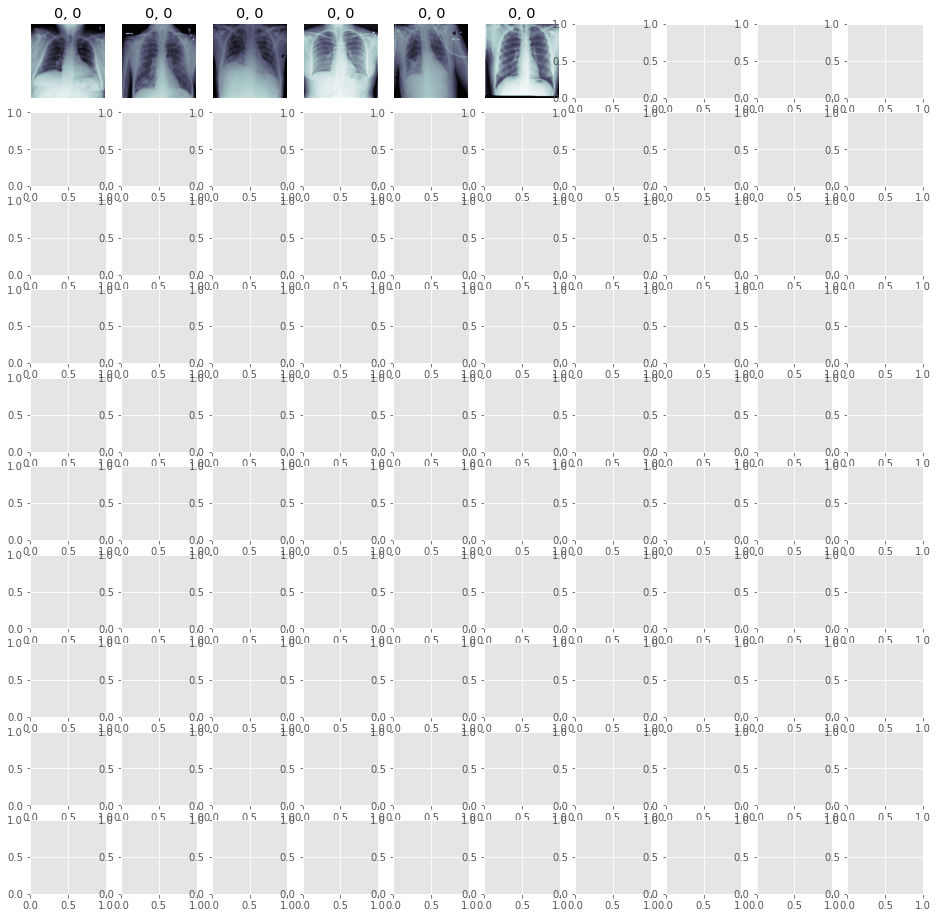

In [32]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1
YOUR_THRESHOLD = 0.3
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
             c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [33]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)